# Best Implementation on Subtask B: Explanation (Multi-Choice)
Updated on August 20, 2021.

#### Project Information:
* Summer Project: Commonsense Validation and Explanation in Natural Language Processing<br>
* Objective Task: SemEval 2020 Task 4 - Commonsense Validation and Explanation (ComVE)<br>
* Supervisor: Dr Mark Lee<br>
* Student: Letian Li (2214560)
 
#### Task Description:
The subtask B is an Explanation (Multi-Choice) task. The purpose is to find the right reason why a given statement is against common sense.

*Example:*  
> **Task:** Select the most appropriate reason as to why this statement is against common sense.  
> **Statement:** He put an elephant into the fridge.  
> A: An elephant is much bigger than a fridge.  
> B: Elephants are usually white while fridges are usually white.  
> C: An elephant cannot eat a fridge.

#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 


Please Note:  
1. In this implementation work, there is no validation process, because it has been carried out in the experiment work. Here, the validation dataset will be used as the training dataset to improve the performance of the best implementation.  
2. The optimal model and hyperparameters selected by the experiment require large storage (over 20G) on the GPU. If you just want to see how this implementation works, you can use a smaller model and batch size.

<!-- #### Task Description:
The subtask B is an Explanation (Multi-Choice) task. The purpose is to find the right reason why a given statement is against common sense.

*Example:* 

     Task: Select the most corresponding reason why this statement is against common sense.  
     Statement: He put an elephant into the fridge.  
     A: An elephant is much bigger than a fridge.  
     B: Elephants are usually white while fridges are usually white.  
     C: An elephant cannot eat a fridge. -->

## 1. General Preparation

Import some common libraries.

In [1]:
from tqdm import tqdm
import time

Use GPU Facilities.

In [2]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:2 - TITAN RTX


Set the model and hyperparameters for implementation.

In [3]:
# Best implementation
model_name = "roberta-large"
optimizer_name = 'Adam'
learning_rate = 1e-5
batch_size = 16
epoch = 5

# # Minor implementation
# model_name = "distilbert-base-uncased"
# optimizer_name = 'Adam'
# learning_rate = 5e-5
# batch_size = 16
# epoch = 3

Set the path to save the trained model.

In [4]:
model_params_path = "./Subtask_B_Best_Model.pth"

## 2. Data Processing

### 2.1 Read data from csv

Build a common function to get texts and labels from csv file.

In [5]:
import pandas as pd
def get_info_from_csv(texts_path, labels_path):
    texts = pd.read_csv(texts_path, header=0, names=['ID', 'False Statement', 'Option A', 'Option B', 'Option C']).fillna(str())
    labels = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])['Answer']
    return texts, labels

Read texts and labels from csv file.

In [6]:
train_texts, train_labels = get_info_from_csv(
    '../DataSet/Training Data/subtaskB_data_all.csv',
    '../DataSet/Training Data/subtaskB_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    '../DataSet/Dev Data/subtaskB_dev_data.csv',
    '../DataSet/Dev Data/subtaskB_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    '../DataSet/Test Data/subtaskB_test_data.csv',
    '../DataSet/Test Data/subtaskB_gold_answers.csv'
)

# Use the validation dataset as the training dataset
train_texts = pd.concat([train_texts, val_texts], axis=0, ignore_index=True)
train_labels = pd.concat([train_labels, val_labels], axis=0, ignore_index=True)

Let's have a look at the training data.

In [7]:
train_data = pd.concat([train_texts, train_labels], axis=1)
train_data

,ID,False Statement,Option A,Option B,Option C,Answer
0,0,He poured orange juice on his cereal.,Orange juice is usually bright orange.,Orange juice doesn't taste good on cereal.,Orange juice is sticky if you spill it on the ...,B
1,1,He drinks apple.,Apple juice are very tasty and milk too,Apple can not be drunk,Apple cannot eat a human,B
2,2,"Jeff ran 100,000 miles today","100,000 miles is way to long for one person to...","Jeff is a four letter name and 100,000 has six...","100,000 miles is longer than 100,000 km.",A
3,3,I sting a mosquito,A human is a mammal,A human is omnivorous,A human has not stings,C
4,4,A giraffe is a person.,Giraffes can drink water from a lake.,A giraffe is not a human being.,.Giraffes usually eat leaves.,B
...,...,...,...,...,...,...
10992,700,THE TEMPERATURE IS EMOTIONAL,THE CLOUD OPENED UP ITS MOUTH AND SAID AHH,WHEN THE WEATHER OUTSIDE IS FRIGHTFUL YOU SHOU...,TEMPERATURES DO NOT HAVE EMOTIONS,C
10993,355,Blended up fruit makes a nacho,"Nachos are triangles, fruits are circle",Nachos are not made up of fruit,A nacho is crispy and blended fruit is mushy,B
10994,1550,Dogs falls from the sky,Dogs aren't usually wet.,Dogs aren't in the sky,The dog can't flying in the sky,B
10995,1364,He put a dinosaur in the fridge,"Dinosaurs are usually big, while refrigerator...",A dinosaur has extincted,Dinosaur can not eat a refrigerator.,B


### 2.2 Tokenization

Define a common function to tokenize texts.

In [8]:
# Tokenization function for subtask B
def tokenize_for_task_B(texts, tokenizer, max_length=128):
    input_ids_list = list()
    attention_mask_list = list()
    
    for text in texts.values:
        encoding = tokenizer([[text[1], text[2]], [text[1], text[3]], [text[1], text[4]]], truncation="longest_first", padding="max_length", max_length=max_length)
        input_ids_list.append(encoding.input_ids)
        attention_mask_list.append(encoding.attention_mask)

    encodings = {"input_ids":input_ids_list,"attention_mask":attention_mask_list}
    return encodings

Tokenization for texts.

In [9]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast, RobertaTokenizerFast

# Get tokenizer
if model_name.startswith("bert"):
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
elif model_name.startswith("distilbert"):
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
elif model_name.startswith("roberta"):
    tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

# Tokenization for texts
train_encodings = tokenize_for_task_B(train_texts, tokenizer)
# val_encodings = tokenize_for_task_B(val_texts, tokenizer)
test_encodings = tokenize_for_task_B(test_texts, tokenizer)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [10]:
class ComVEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Convert labels.

In [11]:
# Convert labels from the letters "A", "B", "C" to the numbers 0, 1, 2
def convert_labels(original_labels):
    labels = [ord(label) - 65 for label in original_labels]
    return labels

train_labels = convert_labels(train_labels)
# val_labels = convert_labels(val_labels)
test_labels = convert_labels(test_labels)

Turn encodings and labels into a Dataset object.

In [12]:
train_dataset = ComVEDataset(train_encodings, train_labels)
# val_dataset = ComVEDataset(val_encodings, val_labels)
test_dataset = ComVEDataset(test_encodings, test_labels)

## 3. Loading the Model and Optimizer

In [13]:
from transformers import BertForMultipleChoice, DistilBertForMultipleChoice, RobertaForMultipleChoice, AdamW

# Loading the model
if model_name.startswith("bert"):
    model = BertForMultipleChoice.from_pretrained(model_name)
elif model_name.startswith("distilbert"):
    model = DistilBertForMultipleChoice.from_pretrained(model_name)
elif model_name.startswith("roberta"):
    model = RobertaForMultipleChoice.from_pretrained(model_name)
model.to(device)

# Loading the optimizer
if optimizer_name == "Adam":
    optim = AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForMultipleChoice: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

## 4. Training

Prepare some utility functions.

In [14]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [15]:
# Training
from torch.utils.data import DataLoader

# Set the number of epochs
epoch = epoch

# Get training data by DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Start training
model.train()

train_loss = list()
train_accuracies = list()
highest_accuracy = 0
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())

        # save the model with the highest accuracy
        if highest_accuracy < accuracy:
            highest_accuracy = accuracy
            torch.save(model.state_dict(), model_params_path) 
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/5


100%|██████████| 688/688 [22:48<00:00,  1.99s/it, loss=0.285, accuracy=0.494]


Epoch 2/5


100%|██████████| 688/688 [14:24<00:00,  1.26s/it, loss=0.115, accuracy=0.896]


Epoch 3/5


100%|██████████| 688/688 [14:35<00:00,  1.27s/it, loss=0.048, accuracy=0.949]


Epoch 4/5


100%|██████████| 688/688 [14:22<00:00,  1.25s/it, loss=0.000, accuracy=0.971]


Epoch 5/5


100%|██████████| 688/688 [14:25<00:00,  1.26s/it, loss=0.001, accuracy=0.985]


Visualise the training loss and accuracy.

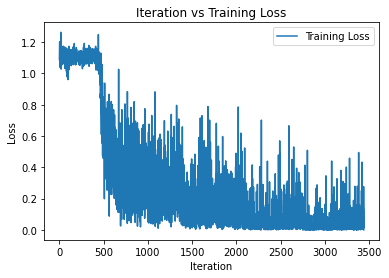

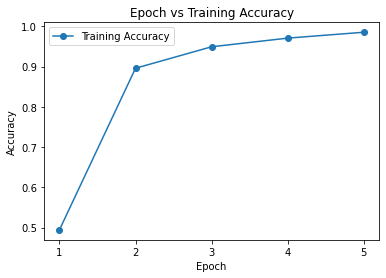

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-o", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [17]:
# Testing
from torch.utils.data import DataLoader

# Load the best-trained model
model.load_state_dict(torch.load(model_params_path))

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = list()
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record.append((int(labels),int(predictions)))
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 1000/1000 [00:31<00:00, 31.35it/s, Loss=0.000, Accuracy=0.918]


The final accuracy on the test dataset: 91.8%


Check the result.

In [18]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

# Convert labels from the numbers 0, 1, 2 to the letters "A", "B", "C"
df_record["Ground Truth"] = df_record["Ground Truth"].map(lambda x:chr(x+65))
df_record["Model Prediction"] = df_record["Model Prediction"].map(lambda x:chr(x+65))

# Concat test texts and test records
df = pd.concat([test_texts, df_record], axis=1)

# Show test result
pd.set_option('display.max_rows', None)
df

,ID,False Statement,Option A,Option B,Option C,Ground Truth,Model Prediction
0,1175,He loves to stroll at the park with his bed,A bed is too heavy to carry with when strollin...,walking at a park is good for health,Some beds are big while some are smaller,A,A
1,452,The inverter was able to power the continent.,An inverter is smaller than a car,An inverter is incapable of powering an entire...,An inverter is rechargeable.,B,B
2,275,The chef put extra lemons on the pizza.,Many types of lemons are to sour to eat.,Lemons and pizzas are both usually round.,Lemons are not a pizza topping.,C,C
3,869,sugar is used to make coffee sour,sugar is white while coffee is brown,sugar can dissolve in the coffee,sugar usually is used as a sweetener,C,C
4,50,There are beautiful planes here and there in t...,A plane flies upon the garden,You can have a small garden in your private plane,A plane can never be seen in garden,C,C
5,1155,"Once a pipe bursts, call a doctor.",Plumbers need to be trained.,plumbers fix the pipes while doctors cure sick...,Pipes come in all different sizes.,B,B
6,1395,Nobody hates paying taxes,Not everybody needs to pay the tax,Taxes eliminate a great amount of our income a...,"Nobody, taxes and everyone are English words",B,B
7,967,all whales are small,whales are actually mammals,whales come in different sizes but almost all ...,whale becomes whale fall after dead and feeds ...,B,B
8,906,the boat enjoyed rolling in the mud,mud is a mix of water and dirt,boats do not have emotions,boats can float on the water,B,B
9,1465,Barbies are the horrible desire for kids,the most horrible thing for the baby is that h...,some kids do not like barbies,There is nothing wrong with kids desiring doll...,C,C


Display the Confusion Matrix of the result.

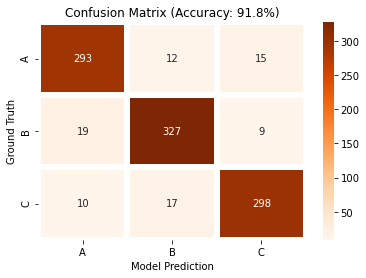

In [19]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()